# 圆波导TE/TM偶极模式横向场分布
本笔记按指定的Bessel函数场表达式绘制圆波导TE/TM偶模式的横向电、磁场线。支持通过模式阶数与根序指定任意模式，并保持电场线为实线、磁场线为虚线，同时描绘波导截面边界。

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

try:
    from scipy import special as sc_special
    HAVE_SCIPY = True
except ImportError:
    sc_special = None
    HAVE_SCIPY = False

try:
    import mpmath as mp
    HAVE_MPMATH = True
except ImportError:
    mp = None
    HAVE_MPMATH = False

MU0 = 4 * np.pi * 1e-7
EPS0 = 8.854187817e-12
C0 = 1 / np.sqrt(MU0 * EPS0)


def _bessel_j(order: int, x: np.ndarray):
    """Integer-order Bessel J_n with SciPy acceleration when available."""
    if HAVE_SCIPY:
        return sc_special.jv(order, x)
    if HAVE_MPMATH:
        vec = np.vectorize(lambda val: float(mp.besselj(order, val)), otypes=[float])
        return vec(x)
    raise ImportError("需要 SciPy 或 mpmath 才能计算Bessel函数。")


def _bessel_j_int(order: int, x: np.ndarray):
    if order >= 0:
        return _bessel_j(order, x)
    return ((-1) ** (-order)) * _bessel_j(-order, x)


def _bessel_j_prime(order: int, x: np.ndarray):
    if HAVE_SCIPY and hasattr(sc_special, "jvp"):
        return sc_special.jvp(order, x)
    return 0.5 * (_bessel_j_int(order - 1, x) - _bessel_j_int(order + 1, x))


def _derivative_zero(order: int, index: int) -> float:
    if HAVE_SCIPY:
        return float(sc_special.jnp_zeros(order, index)[index - 1])
    if not HAVE_MPMATH:
        raise ValueError("若未安装 mpmath，请手动提供 kc 或安装该依赖。")
    def f(val):
        return 0.5 * (mp.besselj(order - 1, val) - mp.besselj(order + 1, val))
    approx = (index + order / 2 - 0.25) * np.pi
    return float(mp.findroot(f, (approx, approx + np.pi / 3)))


def resolve_kc(mode: str, n: int, radius: float, kc: float | None, root_index: int) -> float:
    if kc is not None:
        return kc
    if HAVE_SCIPY:
        if mode.startswith("TE"):
            root = sc_special.jnp_zeros(n, root_index)[root_index - 1]
        else:
            root = sc_special.jn_zeros(n, root_index)[root_index - 1]
        return float(root) / radius
    if not HAVE_MPMATH:
        raise ValueError("未提供 kc 且缺少 mpmath，无法自动求解Bessel零点。")
    if mode.startswith("TE"):
        root = _derivative_zero(n, root_index)
    else:
        root = mp.besseljzero(n, root_index)
    return root / radius


def cylindrical_to_cartesian(Er, Ephi, Hr, Hphi, phi):
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    Ex = Er * cos_phi - Ephi * sin_phi
    Ey = Er * sin_phi + Ephi * cos_phi
    Hx = Hr * cos_phi - Hphi * sin_phi
    Hy = Hr * sin_phi + Hphi * cos_phi
    return Ex, Ey, Hx, Hy


def compute_circular_fields(
    mode: str,
    n: int,
    *,
    radius: float = 0.02,
    freq: float = 10e9,
    root_index: int = 1,
    kc: float | None = None,
    amplitude: float = 1.0,
    grid: int = 241,
    phase: float = np.pi / 2,
    z: float = 0.0,
    mask_outside: bool = True,
    refractive_index: float = 1.0,
 ) -> dict:
    """Compute transverse fields for even-polarized TE/TM circular modes."""
    mode = mode.upper()
    if mode not in {"TE", "TM"}:
        raise ValueError("mode 仅支持 'TE' 或 'TM'")
    if n < 0:
        raise ValueError("模式阶数 n 需为非负整数")

    eps = EPS0 * refractive_index**2
    mu = MU0
    omega = 2 * np.pi * freq
    k = omega * np.sqrt(mu * eps)
    kc_val = resolve_kc(mode, n, radius, kc, root_index)
    kz = np.sqrt((k**2 - kc_val**2) + 0j)
    x = np.linspace(-radius, radius, grid)
    y = np.linspace(-radius, radius, grid)
    X, Y = np.meshgrid(x, y, indexing="xy")
    R = np.sqrt(X**2 + Y**2)
    Phi = np.arctan2(Y, X)
    mask = R <= radius
    phase_factor = np.exp(1j * (kz * z + phase))
    kr = kc_val * R
    Jn = _bessel_j(n, kr)
    Jn_prime = _bessel_j_prime(n, kr)
    cos_term = np.cos(n * Phi)
    sin_term = np.sin(n * Phi)
    with np.errstate(divide="ignore", invalid="ignore"):
        inv_r = np.where(R > 1e-9, 1.0 / R, 0.0)

    Er = np.zeros_like(R, dtype=complex)
    Ephi = np.zeros_like(R, dtype=complex)
    Hr = np.zeros_like(R, dtype=complex)
    Hphi = np.zeros_like(R, dtype=complex)
    Ez = np.zeros_like(R, dtype=complex)
    Hz = np.zeros_like(R, dtype=complex)

    if mode == "TE":
        H0 = amplitude
        Hz = H0 * Jn * cos_term * phase_factor
        Hr = (1j * kz / kc_val) * H0 * Jn_prime * cos_term * phase_factor
        Hphi = (
            -1j * kz * n / (kc_val**2) * H0 * Jn * inv_r * sin_term * phase_factor
        )
        Er = (
            -1j * omega * mu * n / (kc_val**2) * H0 * Jn * inv_r * sin_term * phase_factor
        )
        Ephi = (
            -1j * omega * mu / kc_val * H0 * Jn_prime * cos_term * phase_factor
        )
    else:
        E0 = amplitude
        Ez = E0 * Jn * cos_term * phase_factor
        Er = (1j * kz / kc_val) * E0 * Jn_prime * cos_term * phase_factor
        Ephi = (
            -1j * kz * n / (kc_val**2) * E0 * Jn * inv_r * sin_term * phase_factor
        )
        Hr = (
            1j * omega * eps * n / (kc_val**2) * E0 * Jn * inv_r * sin_term * phase_factor
        )
        Hphi = (
            1j * omega * eps / kc_val * E0 * Jn_prime * cos_term * phase_factor
        )

    Ex, Ey, Hx, Hy = cylindrical_to_cartesian(Er, Ephi, Hr, Hphi, Phi)

    if mask_outside:
        mask_nan = np.where(R <= radius, 1.0, np.nan)
        Ex, Ey, Hx, Hy = (Ex * mask_nan, Ey * mask_nan, Hx * mask_nan, Hy * mask_nan)
        Ez = Ez * mask_nan
        Hz = Hz * mask_nan

    data = {
        "x": x,
        "y": y,
        "Ex": np.real(Ex),
        "Ey": np.real(Ey),
        "Hx": np.real(Hx),
        "Hy": np.real(Hy),
        "Ez": np.real(Ez),
        "Hz": np.real(Hz),
        "mode": mode,
        "n": n,
        "radius": radius,
        "freq": freq,
        "kc": kc_val,
        "kz": kz,
    }
    return data


def plot_circular_mode(
    mode: str,
    n: int,
    *,
    radius: float = 0.02,
    freq: float = 10e9,
    root_index: int = 1,
    kc: float | None = None,
    amplitude: float = 1.0,
    grid: int = 241,
    phase: float = np.pi / 2,
    z: float = 0.0,
    refractive_index: float = 1.0,
    density: float = 1.3,
    figsize: tuple[float, float] = (8.0, 8.0),
    dpi: int = 220,
 ):
    """Plot transverse electric (solid) and magnetic (dashed) field lines for circular guides."""
    fields = compute_circular_fields(
        mode,
        n,
        radius=radius,
        freq=freq,
        root_index=root_index,
        kc=kc,
        amplitude=amplitude,
        grid=grid,
        phase=phase,
        z=z,
        refractive_index=refractive_index,
    )
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    e_stream = ax.streamplot(
        fields["x"],
        fields["y"],
        fields["Ex"],
        fields["Ey"],
        color="tab:blue",
        linewidth=1.5,
        density=density,
    )
    h_stream = ax.streamplot(
        fields["x"],
        fields["y"],
        fields["Hx"],
        fields["Hy"],
        color="tab:orange",
        linewidth=1.3,
        density=density,
    )
    h_stream.lines.set_linestyle((0, (6, 3)))

    circle = Circle((0.0, 0.0), radius, linewidth=2.2, edgecolor="black", facecolor="none")
    ax.add_patch(circle)

    ax.set_xlim(-1.05 * radius, 1.05 * radius)
    ax.set_ylim(-1.05 * radius, 1.05 * radius)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x (m)", fontsize=12)
    ax.set_ylabel("y (m)", fontsize=12)
    title = f"{fields['mode']}_{fields['n']}{root_index}  @  {freq / 1e9:.2f} GHz"
    ax.set_title(title, fontsize=14)

    legend_handles = [
        Line2D([], [], color="tab:blue", lw=1.8, label="E field (solid)"),
        Line2D([], [], color="tab:orange", lw=1.8, linestyle=(0, (6, 3)), label="H field (dashed)"),
        Line2D([], [], color="black", lw=2.2, label="Waveguide wall"),
    ]
    ax.legend(handles=legend_handles, loc="upper right", fontsize=11)
    ax.tick_params(labelsize=11)
    ax.grid(False)
    plt.tight_layout()
    return fig, ax

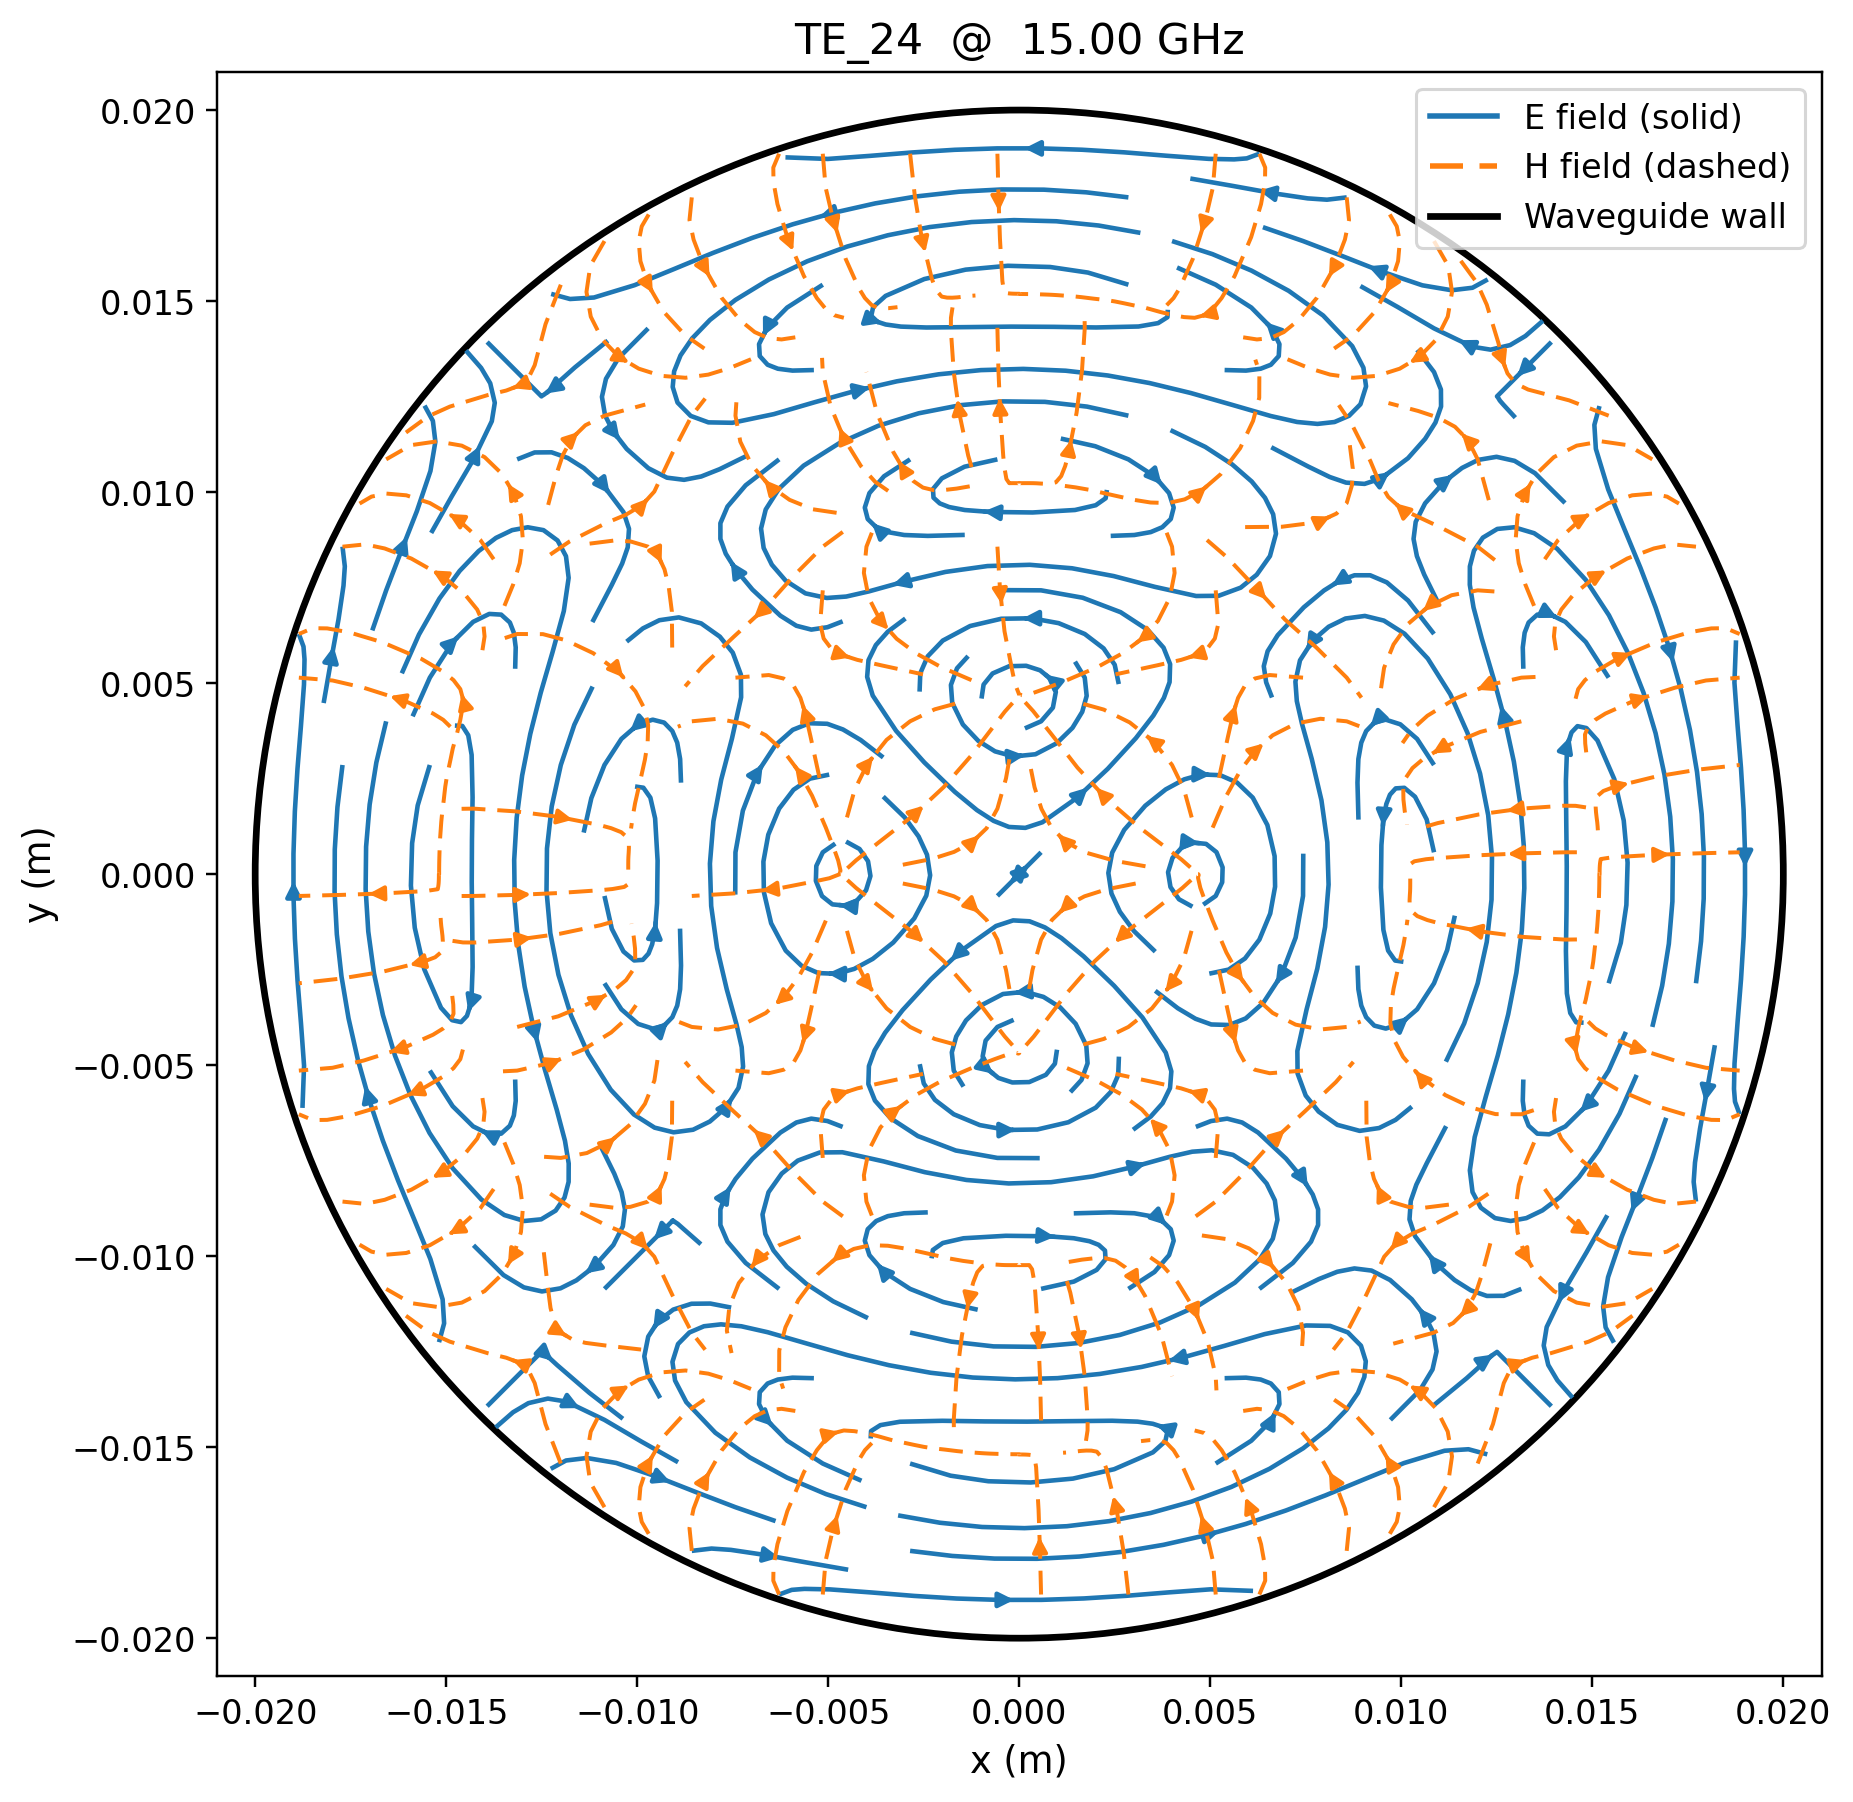

In [22]:
# TE11 偶极模式示意
plot_circular_mode(
    mode="TE",
    n=2,
    root_index=4,
    radius=0.02,
    freq=15e9,
    amplitude=1.0,
    grid=1000,
    density=1.2,
    phase=np.pi / 2,
    figsize=(8.5, 8.5),
);

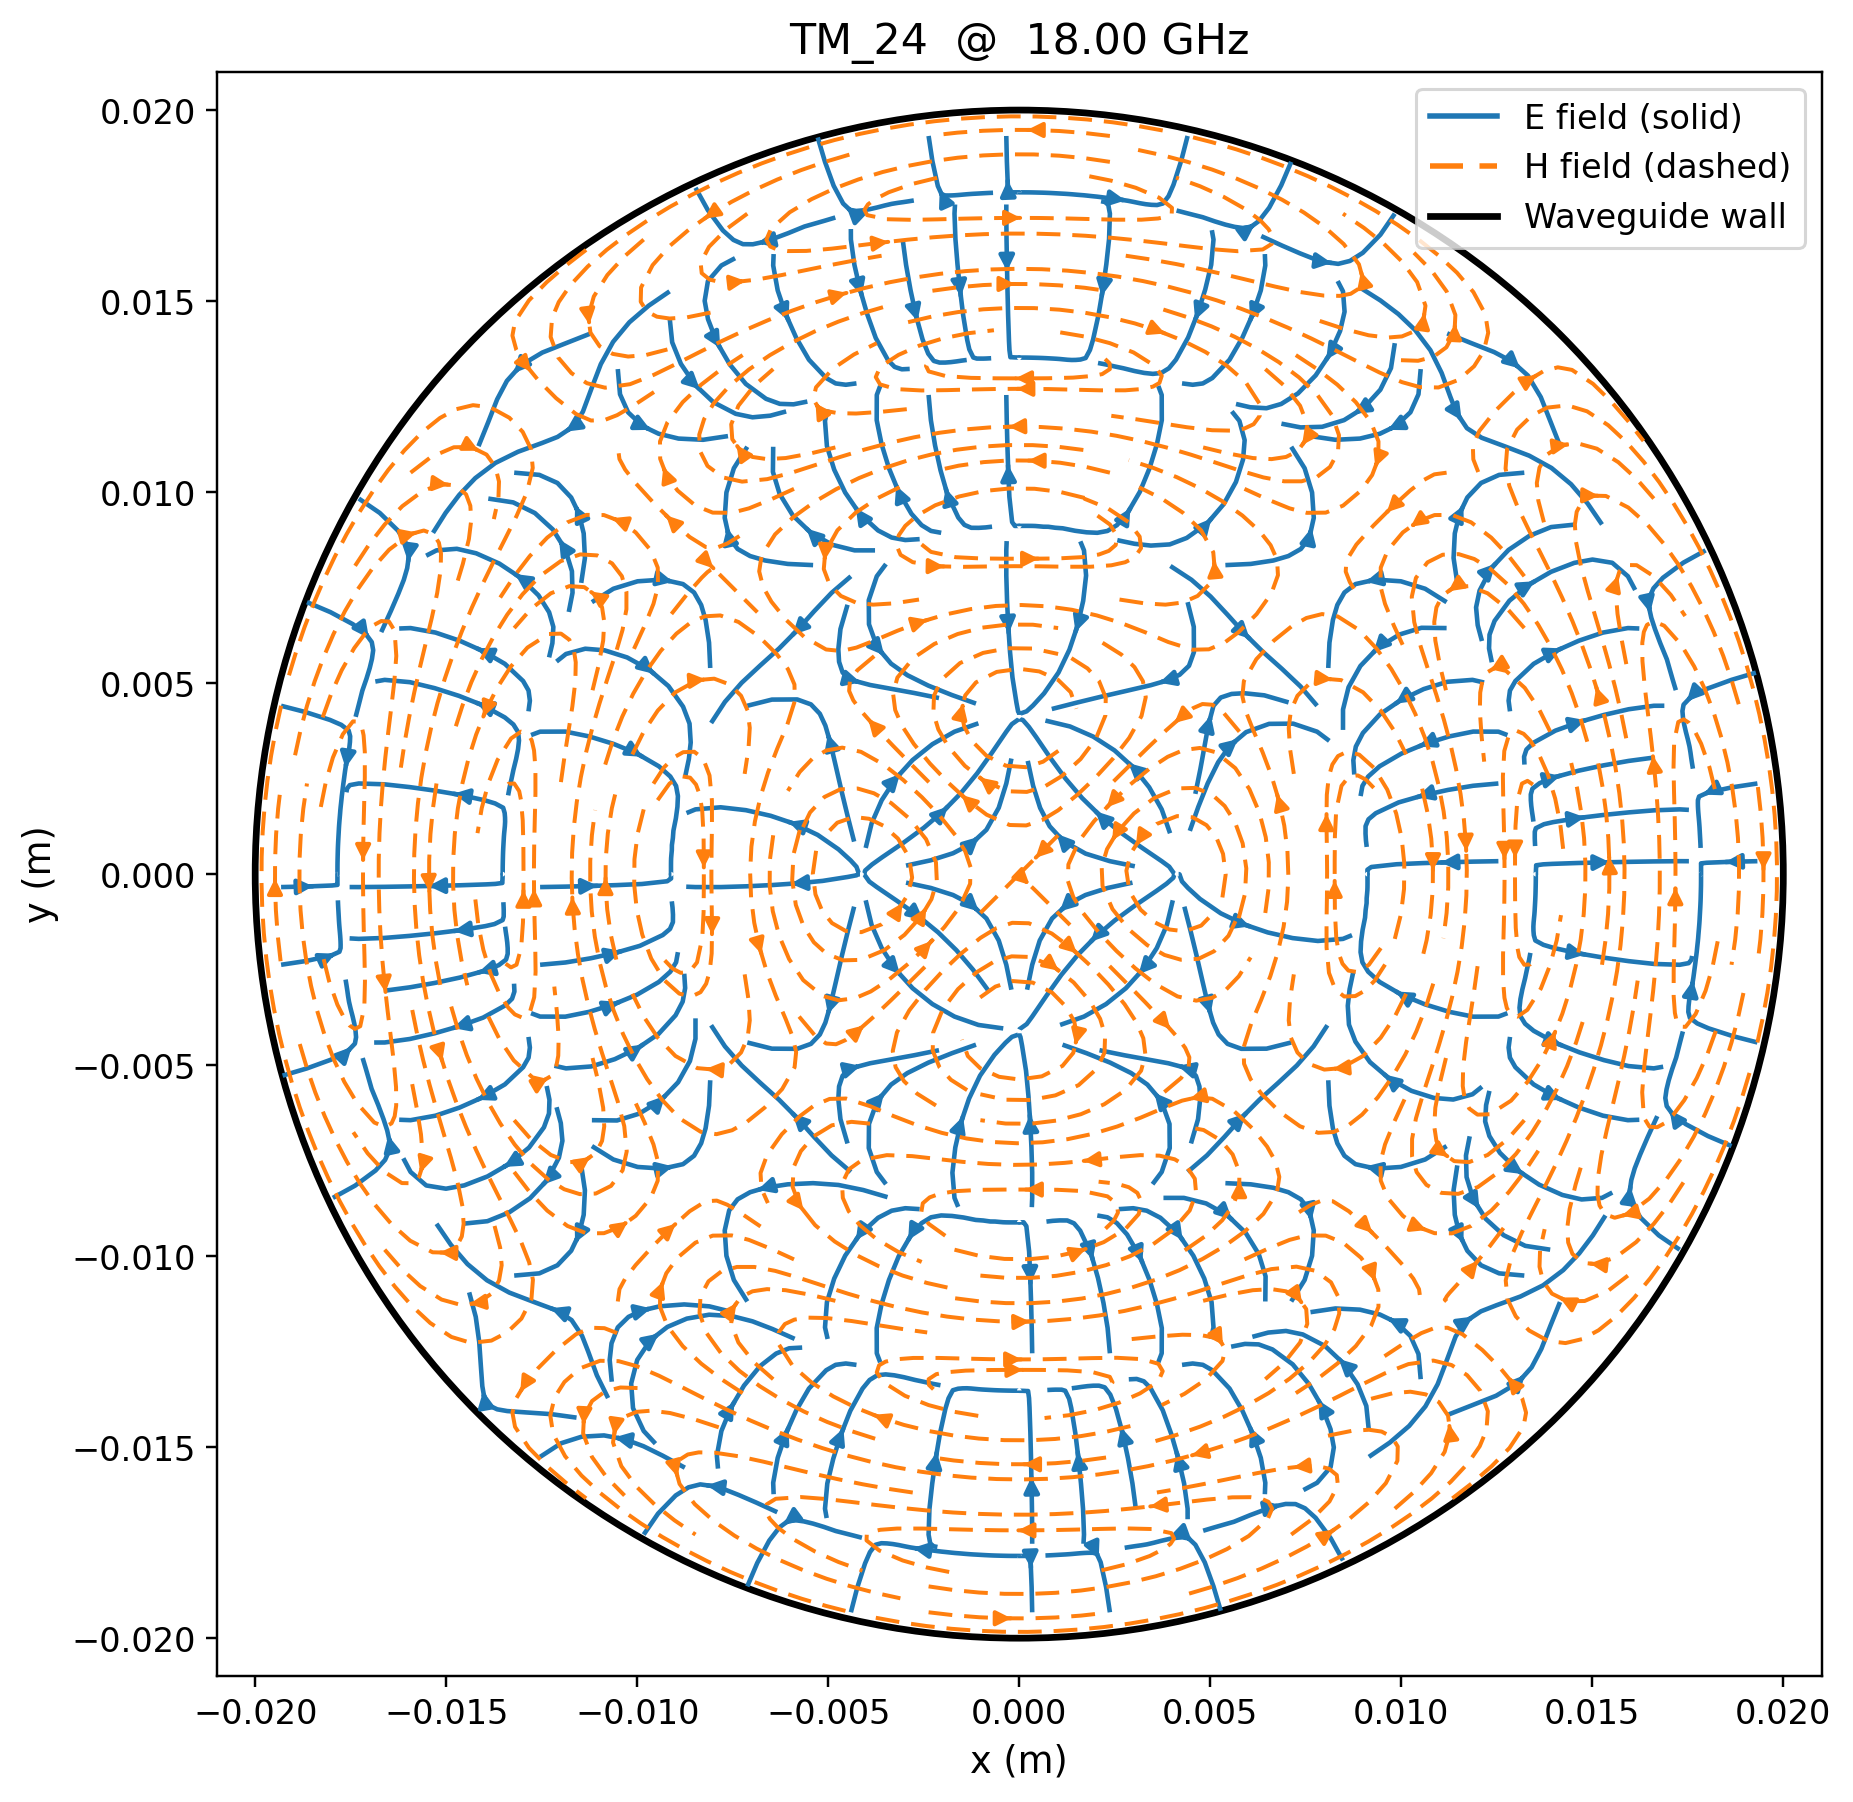

In [25]:
# TM01 偶极模式示意
plot_circular_mode(
    mode="TM",
    n=2,
    root_index=4,
    radius=0.02,
    freq=18e9,
    amplitude=1.0,
    grid=1000,
    density=2,
    phase=np.pi / 2,
    figsize=(8.5, 8.5),
);